# NLP procedures

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/jobs.csv")

df.shape
df.head()


,unnamed:_0,index,job_title,salary_estimate,job_description,rating,company_name,location,headquarters,size,...,revenue,competitors,easy_apply,min_salary_k,max_salary_k,avg_salary_k,company_name_clean,job_family,seniority,job_description_clean
0,0,0,Senior Data Scientist,$111K-$181K (Glassdoor est.),"ABOUT HOPPER\n\nAt Hopper, we’re on a mission ...",3.5,Hopper\n3.5,"New York, NY","Montreal, Canada",501 to 1000 employees,...,Unknown / Non-Applicable,-1,-1,111.0,181.0,146.0,Hopper,data_scientist,senior,about hopper at hopper we re on a mission to m...
1,1,1,"Data Scientist, Product Analytics",$111K-$181K (Glassdoor est.),"At Noom, we use scientifically proven methods ...",4.5,Noom US\n4.5,"New York, NY","New York, NY",1001 to 5000 employees,...,Unknown / Non-Applicable,-1,-1,111.0,181.0,146.0,Noom US,data_scientist,regular,at noom we use scientifically proven methods t...
2,2,2,Data Science Manager,$111K-$181K (Glassdoor est.),Decode_M\n\nhttps://www.decode-m.com/\n\nData ...,-1.0,Decode_M,"New York, NY","New York, NY",1 to 50 employees,...,Unknown / Non-Applicable,-1,True,111.0,181.0,146.0,Decode_M,other,manager,decode m https www.decode m.com data science m...
3,3,3,Data Analyst,$111K-$181K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,...,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1,111.0,181.0,146.0,Sapphire Digital,data_analyst,regular,sapphire digital seeks a dynamic and driven mi...
4,4,4,"Director, Data Science",$111K-$181K (Glassdoor est.),"Director, Data Science - (200537)\nDescription...",3.4,United Entertainment Group\n3.4,"New York, NY","New York, NY",51 to 200 employees,...,Unknown / Non-Applicable,"BBDO, Grey Group, Droga5",-1,111.0,181.0,146.0,United Entertainment Group,other,regular,director data science 200537 description edelm...


In [3]:
df["job_description_clean"].isna().mean()
df = df[df["job_description_clean"].notna()].reset_index(drop=True)
df.shape

(3909, 24)

# TF-IDF Vectorization 

In [4]:
tfidf = TfidfVectorizer(
    max_features=10_000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=10
)

X_tfidf = tfidf.fit_transform(df["job_description_clean"])
X_tfidf.shape

(3909, 10000)

In [5]:
feature_names = np.array(tfidf.get_feature_names_out())

tfidf_means = X_tfidf.mean(axis=0).A1
top_terms = feature_names[np.argsort(tfidf_means)[-20:]]

top_terms

array(['strong', 'machine learning', 'knowledge', 'job', 'machine',
       'solutions', 'research', 'ability', 'years', 'analysis', 'science',
       'development', 'analytics', 'learning', 'skills', 'team', 'work',
       'business', 'experience', 'data'], dtype=object)

In [6]:
def top_terms_for_group(group_idx, top_n=15):
    mean_tfidf = X_tfidf[group_idx].mean(axis=0).A1
    return feature_names[np.argsort(mean_tfidf)[-top_n:]]

top_families = df["job_family"].value_counts().head(8).index

skills_by_role = {}

for fam in top_families:
    idx = df[df["job_family"] == fam].index
    skills_by_role[fam] = top_terms_for_group(idx, 15)

skills_by_role

{'other': array(['science', 'job', 'cell', 'ability', 'clinical', 'required',
        'skills', 'team', 'business', 'development', 'laboratory', 'work',
        'research', 'experience', 'data'], dtype=object),
 'data_scientist': array(['scientist', 'statistical', 'team', 'work', 'analytics', 'models',
        'data scientist', 'data science', 'machine learning', 'machine',
        'science', 'business', 'learning', 'experience', 'data'],
       dtype=object),
 'data_analyst': array(['team', 'analytics', 'ability', 'sql', 'reports', 'reporting',
        'management', 'skills', 'work', 'analysis', 'data analyst',
        'business', 'analyst', 'experience', 'data'], dtype=object),
 'data_engineer': array(['solutions', 'sql', 'pipelines', 'big data', 'years', 'work',
        'big', 'aws', 'spark', 'cloud', 'business', 'data engineer',
        'engineer', 'experience', 'data'], dtype=object),
 'ml_engineer': array(['work', 'team', 'deep learning', 'engineer', 'deep', 'models',
        'al

# Convert skills to a readable table

In [7]:
skills_table = (
    pd.DataFrame.from_dict(skills_by_role, orient="index")
    .reset_index()
    .rename(columns={"index": "job_family"})
)

skills_table.to_csv("../data/top_skills_by_role.csv", index=False)
cos_sim = cosine_similarity(X_tfidf)
cos_sim.shape

(3909, 3909)

In [8]:
df["job_title_clean"] = df["job_title"].astype(str).str.lower().str.strip()
def get_similar_jobs(job_index, top_n=5):
    scores = cos_sim[job_index]
    similar_idx = np.argsort(scores)[::-1][1:top_n+1]

    return df.loc[similar_idx, [
        "job_title_clean",
        "job_family"
    ]]

get_similar_jobs(10, top_n=5)

,job_title_clean,job_family
301,senior data scientist - algorithms,data_scientist
122,data scientist,data_scientist
2896,machine learning scientist,ml_engineer
223,data scientist,data_scientist
3018,machine learning engineer,ml_engineer


In [9]:
def average_similarity_between_roles(role_a, role_b):
    idx_a = df[df["job_family"] == role_a].index
    idx_b = df[df["job_family"] == role_b].index
    return cos_sim[np.ix_(idx_a, idx_b)].mean()


average_similarity_between_roles("Data Scientist", "ML Engineer")

/var/folders/81/8_283ht15jb5qg569496r8p00000gn/T/ipykernel_73537/604657654.py:4: RuntimeWarning: Mean of empty slice
  return cos_sim[np.ix_(idx_a, idx_b)].mean()
/Users/ificouldcode/Desktop/Project/push3/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


np.float64(nan)

# Role similarity matrix 

In [10]:
roles = df["job_family"].value_counts().head(6).index.tolist()

sim_matrix = pd.DataFrame(
    [[average_similarity_between_roles(a, b) for b in roles] for a in roles],
    index=roles,
    columns=roles
)

sim_matrix

,other,data_scientist,data_analyst,data_engineer,ml_engineer,product
other,0.073024,0.073163,0.068027,0.065956,0.063337,0.077299
data_scientist,0.073163,0.111385,0.082329,0.088741,0.100508,0.074864
data_analyst,0.068027,0.082329,0.096560,0.082030,0.062771,0.070376
data_engineer,0.065956,0.088741,0.082030,0.113898,0.081716,0.065821
ml_engineer,0.063337,0.100508,0.062771,0.081716,0.148250,0.063919
product,0.077299,0.074864,0.070376,0.065821,0.063919,0.165210


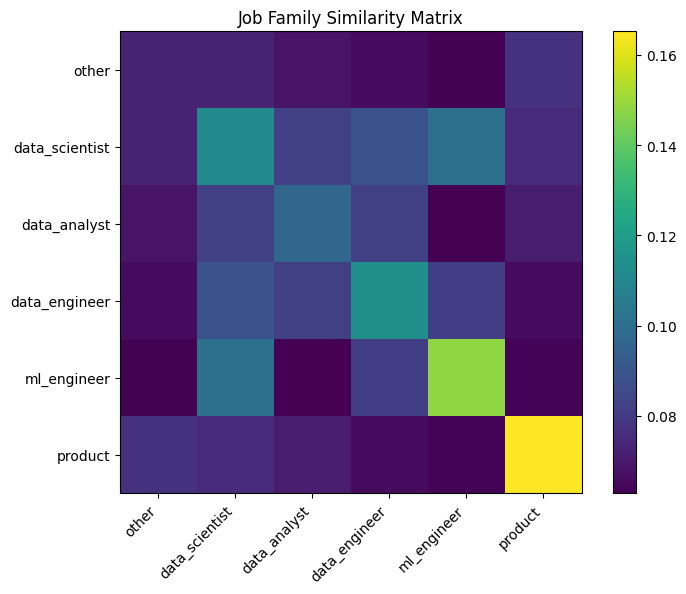

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(sim_matrix, cmap="viridis")
plt.colorbar()
plt.xticks(range(len(roles)), roles, rotation=45, ha="right")
plt.yticks(range(len(roles)), roles)
plt.title("Job Family Similarity Matrix")
plt.show()

In [15]:
import joblib

joblib.dump(tfidf, "../backend/models/tfidf_vectorizer.pkl")
joblib.dump(X_tfidf, "../backend/models/tfidf_matrix.pkl")
joblib.dump(df, "../backend/models/jobs_reference.pkl")

['../backend/models/jobs_reference.pkl']